# Project 1 (Part A)
In this section we investigate the efficacy of various neural network architectures applied to the Parkinson's classification dataset available on the UCI Machine Learning Repository.

## Exploratory Data Analysis
We begin by importing the data and generating some summary visuals.

In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader

from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.svm import SVC

from sklearn import preprocessing

from matplotlib.gridspec import GridSpec

In [31]:
raw_data = pd.read_csv('../data/parkinsons/train_data.txt', header=None)
raw_data = raw_data.drop([0, 27], axis=1)
raw_data[[20]] = raw_data[[20]].astype('float64')
raw_data[[21]] = raw_data[[21]].astype('float64')
raw_data[[25]] = raw_data[[25]].astype('float64')
raw_data[[28]] = raw_data[[28]].astype('int64')

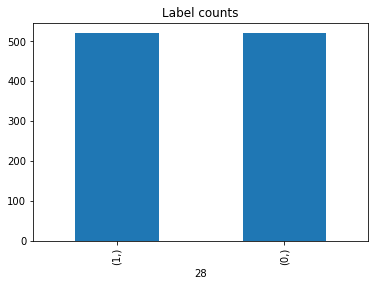

In [32]:
raw_data[[28]].value_counts().plot(kind='bar', title='Label counts')
plt.show()

Fortunately the dataset is balanced, in that we have an equal number of examples of each class. This will facilitate training later on. What about the distribution of our 26 input variables?

In [52]:
X = raw_data.loc[:,:26].values
y = raw_data[[28]].values.ravel()

In [57]:
X_scaled = preprocessing.scale(X)

In [58]:
tsne = TSNE()
X_reduced = tsne.fit_transform(X_scaled)

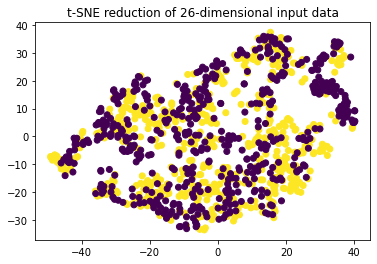

In [59]:
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=y)
plt.title('t-SNE reduction of 26-dimensional input data')
plt.show()

Using $t$-SNE, a dimensionality-reduction algorithm, we are able to visualise the 26 inputs dimensions in a scatter plot. Unfortunately it appears that many examples of different classes are clustered together, which suggests that training an accurate classifier may be difficult.

## Experimenting with a simple classifier
Before building a neural network, we first experiment with two traditional classifiers to establish a baseline level of performance.

In [68]:
model = LogisticRegression()

model.fit(X_scaled,y)
model.score(X_scaled,y)

0.65

So with an $\ell_2$-regularised logistic regression classifier, we have obtained a baseline accuracy of $65\%$ on the training set.

In [70]:
model = SVC()

model.fit(X_scaled,y)
model.score(X_scaled,y)

0.7375

Meanwhile with an out-of-the-box support vector machine, we have obtained a baseline accurace of $74\%$ on the training set. This will be our figure to beat. 

## Building a neural network
We now proceed to building the neural network which will be used to classify the data.

In [71]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(26,128)
        self.fc2 = nn.Linear(128,2)
        
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        
        return x

In [72]:
model = Net()

## Training a neural network
We are now ready to train our neural network.

In [73]:
X_train, X_test, y_train, y_test = train_test_split(
                                    X_scaled, y, test_size=0.20, random_state=42)

In [144]:
train_dataset = TensorDataset(
    torch.from_numpy(X_train).type(torch.float),
    torch.from_numpy(y_train)
)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(
    torch.from_numpy(X_test).type(torch.float),
    torch.from_numpy(y_test)
)

test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [145]:
model = Net()

In [146]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.03)

In [147]:
n_epochs = 200

train_losses = []
test_losses = []
test_accuracies = []

for e in range(n_epochs):
    
    model.train()
    for ii, (inputs, labels) in enumerate(train_dataloader):
        optimizer.zero_grad() 

        logits = model(inputs)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        train_losses.append(loss.item() / inputs.shape[0])
    
    
    test_loss = 0
    accuracy = 0
    
    model.eval()
    for ii, (inputs, labels) in enumerate(test_dataloader):
        with torch.no_grad():
            logits = model(inputs)
            loss = criterion(logits, labels)

            test_loss += loss.item() / inputs.shape[0]

            preds = logits.argmax(dim=1)
            
            correct = (preds == labels).type(torch.FloatTensor)
            accuracy += torch.mean(correct).item()
        
    test_losses.append(test_loss)
    test_accuracies.append(accuracy / len(test_dataloader))

In [160]:
window_length = 25

train_losses_skipped = [train_losses[i] for i, item in enumerate(train_losses) if i % window_length == 0]
train_losses_averaged = np.convolve(np.array(train_losses), np.ones((window_length,))/window_length, mode='valid')

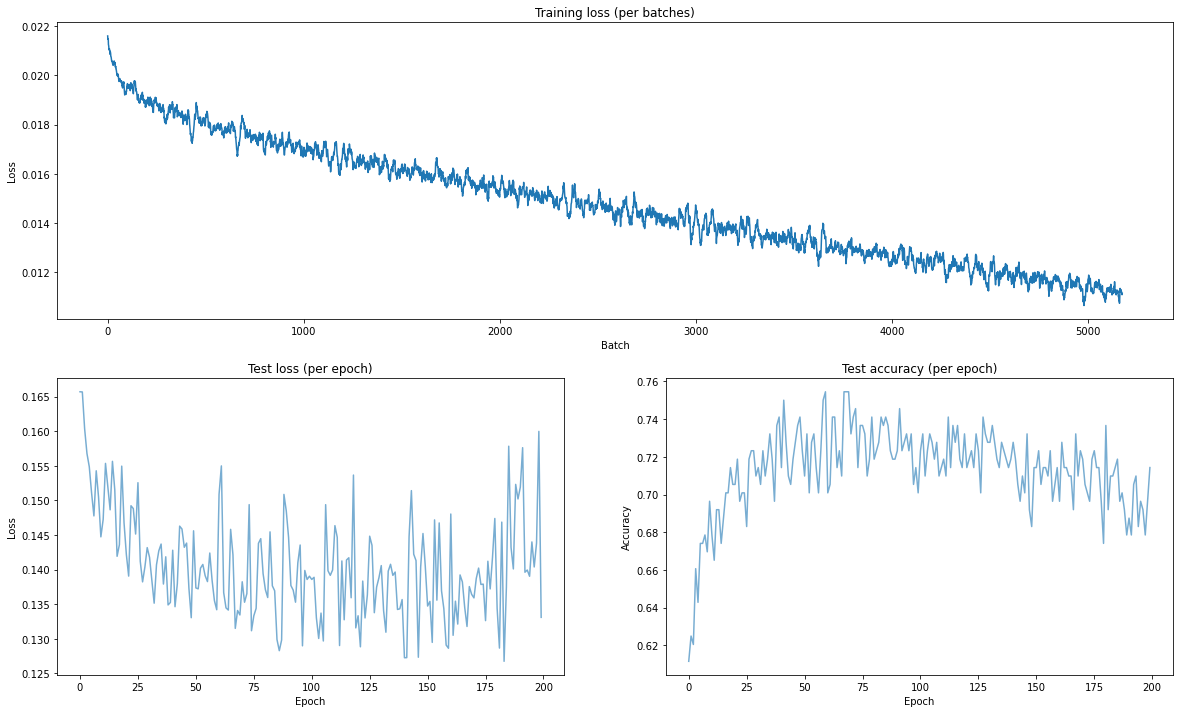

In [161]:
fig = plt.figure(figsize=(20,12))
gs = GridSpec(2, 2, figure=fig)
ax1 = plt.subplot(gs[0, :])
ax2 = plt.subplot(gs[1, 0])
ax3 = plt.subplot(gs[1, 1])

ax1.plot(train_losses_averaged)
ax2.plot(test_losses, alpha=0.6)
ax3.plot(test_accuracies, alpha=0.6)

ax1.set_title('Training loss (per batches)')
ax1.set_xlabel('Batch')
ax1.set_ylabel('Loss')

ax2.set_title('Test loss (per epoch)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')

ax3.set_title('Test accuracy (per epoch)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')

plt.show()